In [2]:
import scanpy as sc
import spatialdata

Tissue = "Region3"
TableFolder = "REGION3_TABLES"

adata = sc.read_h5ad(f"/Volumes/ProstateCancerEvoMain/dbs/Ongoing/{Tissue}/{TableFolder}/{Tissue}_Xenium_Phen_HE_Integrated.Xenium_Native_Table.Phen_and_ImagePropsEnriched.V2.h5ad")
adata

AnnData object with n_obs × n_vars = 169163 × 5101
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'DAPI_PhenCyc', 'CD8_PhenCyc', 'CD31_PhenCyc', 'CD11c_PhenCyc', 'CD34_PhenCyc', 'CD20_PhenCyc', 'CD4_PhenCyc', 'CD21_PhenCyc', 'Ki67_PhenCyc', 'CD68_PhenCyc', 'E_cadherin_PhenCyc', 'pten_PhenCyc', 'NF-H_PhenCyc', 'FOXp3_PhenCyc', 'CD45_PhenCyc', 'TFAM_PhenCyc', 'PDL-1_PhenCyc', 'SOX2_PhenCyc', 'Vimentin_PhenCyc', 'HIF1A_PhenCyc', 'CD44_PhenCyc', 'Keratin_8_18_PhenCyc', 'aSMA_PhenCyc', 'EpCAM_PhenCyc', 'K14_PhenCyc', 'area', 'centroid-0', 'centroid-1', 'centroid_local-1', 'centroid_weighted_local-0', 'centroid_weighted_local-1', 'euler_number', 'extent', 'feret_diameter_max', 'intensity_max', 'intensity_min', 'intensity_mean', 'solidity', 'eccentricity', 'pe

In [ ]:
## 
adata_for_annotation = sc.read_h5ad(f"/Volumes/ProstateCancerEvoMain/dbs/Ongoing/{Tissue}/{TableFolder}/{Tissue}_Xenium_Phen_HE_Integrated.Xenium_Process_Table.Cell_Type_Annotated_Auto.V3.All_Genes.h5ad")
adata.obs["cell_type_xenium_panel"] = adata_for_annotation.obs["cell_type_xenium_panel"].values

In [54]:
mask = adata.obs["cell_type_xenium_panel"] == "tumor_cell_markers"
adata = adata[mask, :].copy()

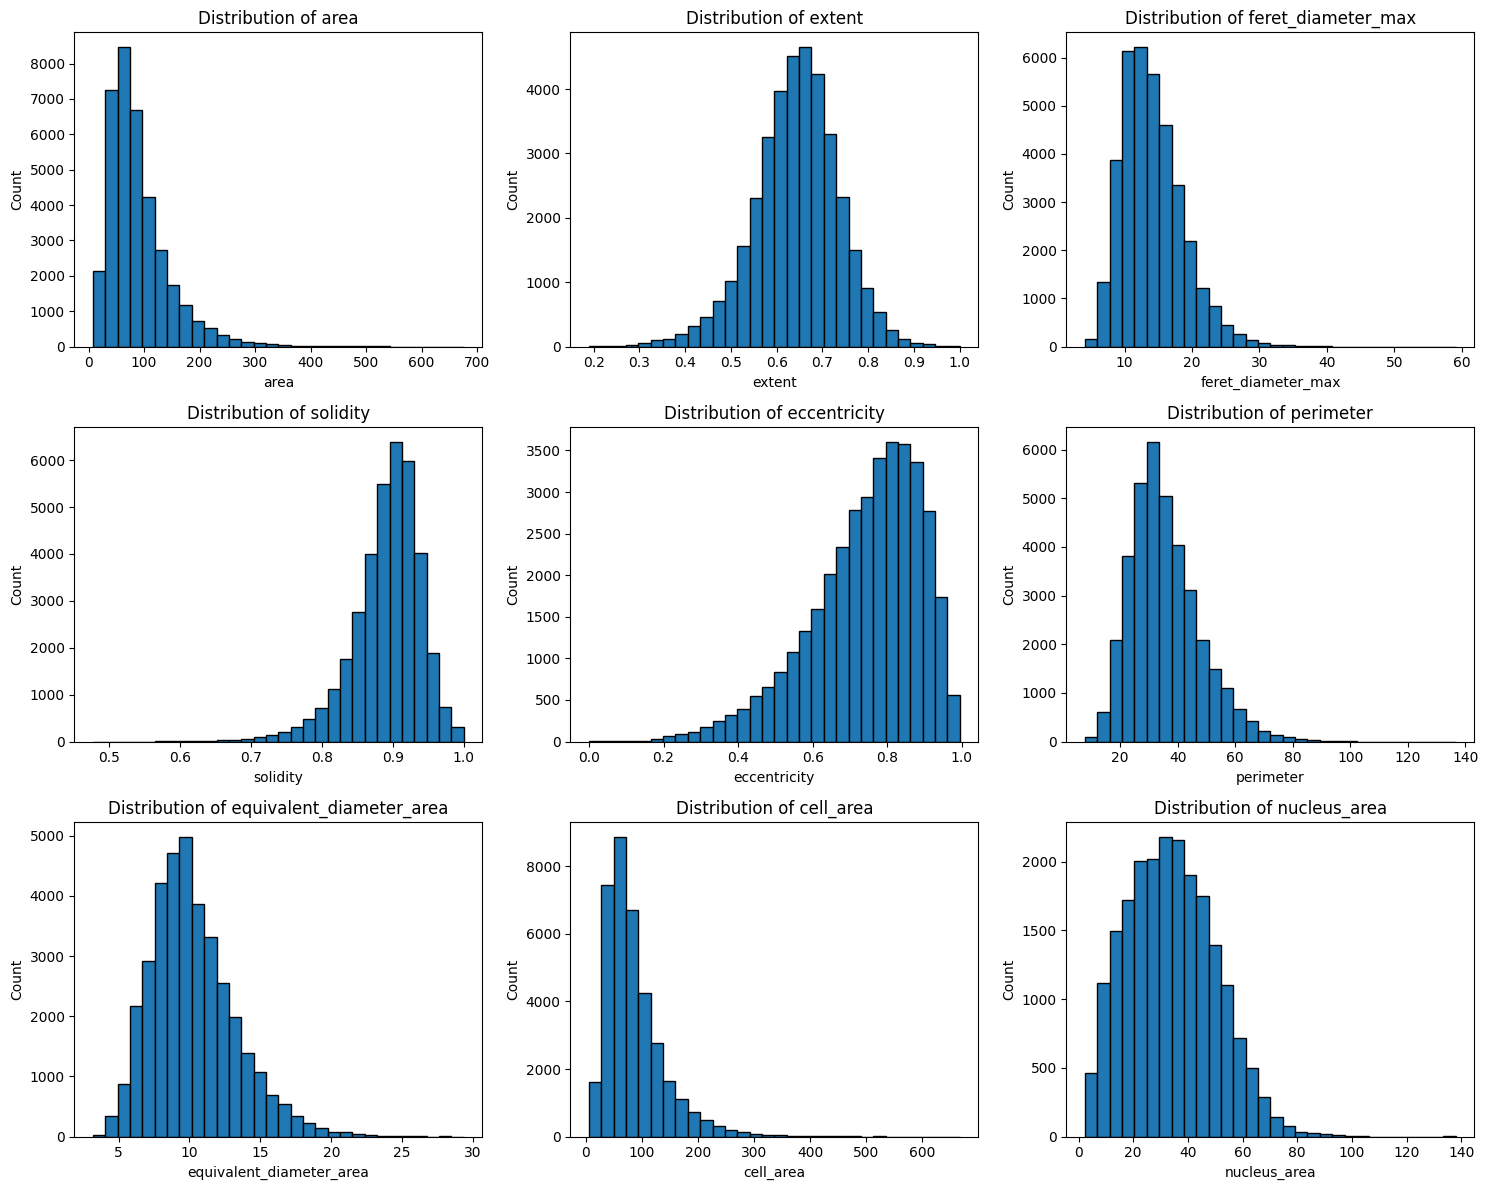

In [92]:
import matplotlib.pyplot as plt
import pandas as pd

features = [
    'area', 'extent', 'feret_diameter_max',
    'solidity', 'eccentricity', 'perimeter',
    'equivalent_diameter_area', 'cell_area', 'nucleus_area'
]

# coerce to numeric (errors → NaN)
df = adata.obs[features].apply(pd.to_numeric, errors='coerce')

# set up 3×3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for ax, feat in zip(axes, features):
    vals = df[feat].dropna()
    ax.hist(vals, bins=30, edgecolor='black')
    ax.set_title(f'Distribution of {feat}')
    ax.set_xlabel(feat)
    ax.set_ylabel('Count')

fig.tight_layout()
plt.show()

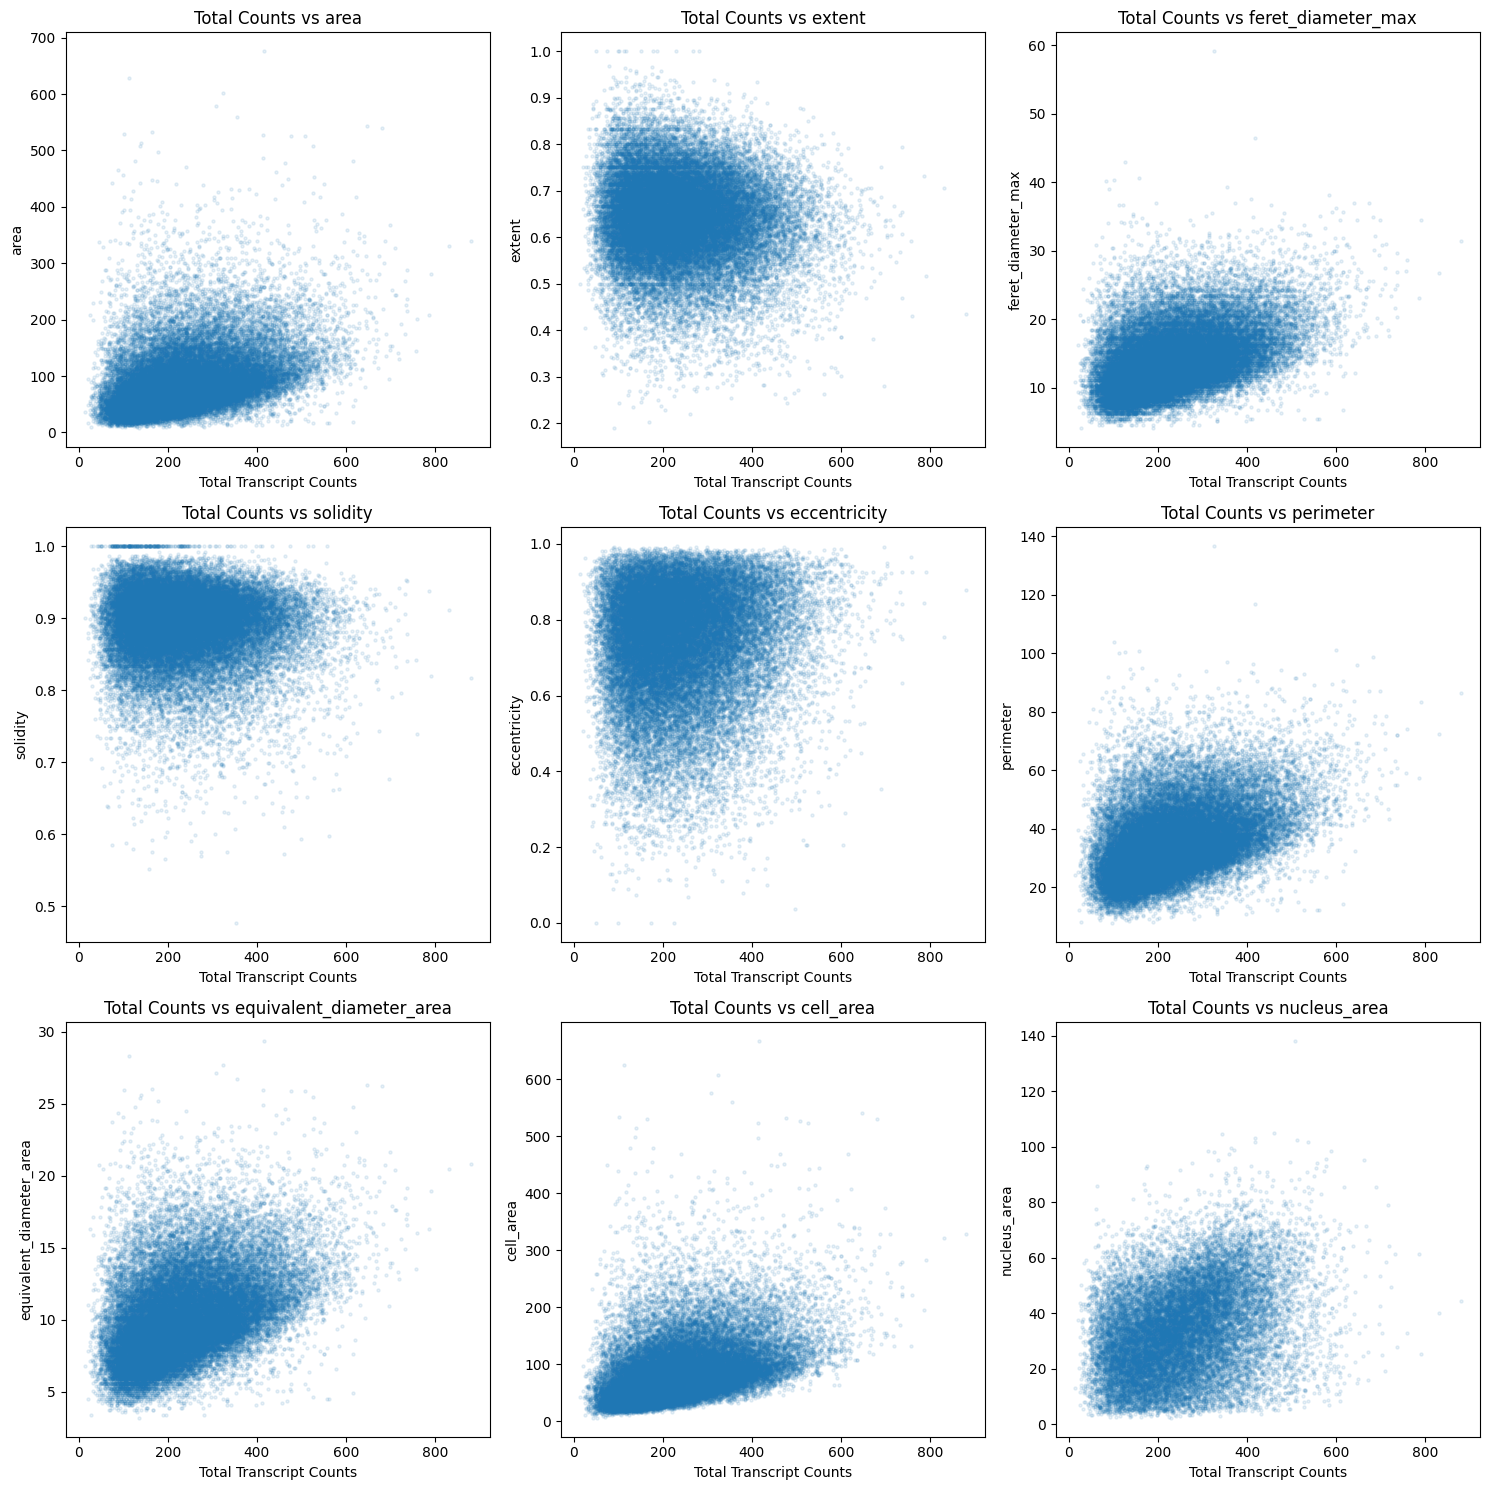

In [94]:
features = [
    'area', 'extent', 'feret_diameter_max',
    'solidity', 'eccentricity', 'perimeter',
    'equivalent_diameter_area', 'cell_area', 'nucleus_area'
]

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

X = adata.X

if hasattr(X, "toarray"):
    total_counts = np.array(X.toarray()).sum(axis=1)
else:
    total_counts = np.array(X).sum(axis=1)
adata.obs['total_counts'] = total_counts


plot_feats = [f for f in features if f in adata.obs.columns][:9]

# 3) Convert to numeric
df = adata.obs[plot_feats].apply(pd.to_numeric, errors='coerce')
df['total_counts'] = adata.obs['total_counts']

# 4) Plot 3×3 scatter grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for ax, feat in zip(axes, plot_feats):
    mask = df[feat].notna()
    ax.scatter(df['total_counts'][mask], df[feat][mask], s=5, alpha=0.1)
    ax.set_xlabel('Total Transcript Counts')
    ax.set_ylabel(feat)
    ax.set_title(f'Total Counts vs {feat}')

fig.tight_layout()
plt.show()


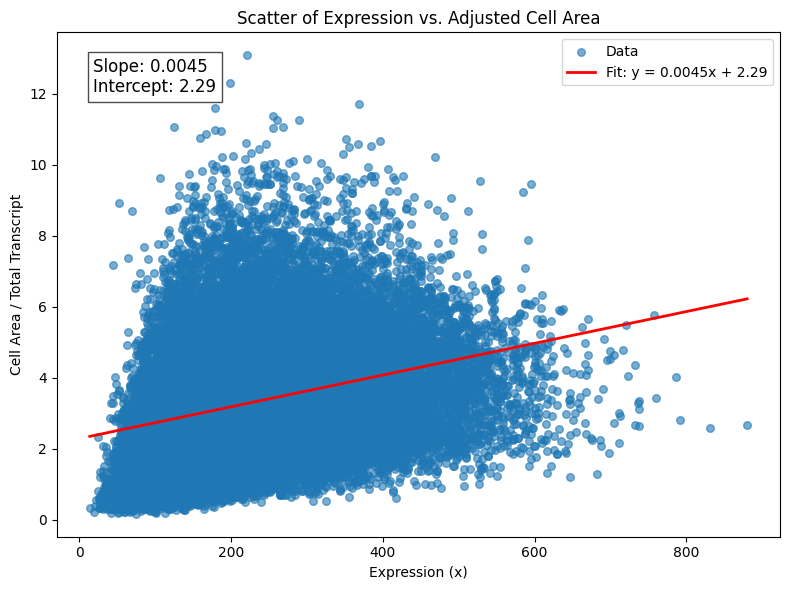

In [104]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

x = np.array(adata.X.toarray()).sum(axis=1)   # shape (n_cells,)
y = np.asarray(adata.obs["cell_area"])


y_Tsize = x/y 
slope, intercept, r_value, p_value, std_err = linregress(x, y_Tsize)
x_line = np.linspace(min(x), max(x), 100)
y_line = slope * x_line + intercept

# Plot using matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y_Tsize, alpha=0.6, s=30, label='Data')
ax.plot(x_line, y_line, color='red', linewidth=2, label=f'Fit: y = {slope:.4f}x + {intercept:.2f}')

# Annotation
annotation_text = f"Slope: {slope:.4f}\nIntercept: {intercept:.2f}"
ax.text(0.05, 0.95, annotation_text, transform=ax.transAxes,
        fontsize=12, verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.7))

# Labels and title
ax.set_xlabel("Expression (x)")
ax.set_ylabel("Cell Area / Total Transcript")
ax.set_title("Scatter of Expression vs. Adjusted Cell Area")
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.stats import linregress

# 0) Precompute T once as a 1-D array
expr = adata.X

if hasattr(expr, "toarray"):
    T = np.array(expr.toarray()).sum(axis=1)
else:
    T = np.asarray(expr.sum(axis=1)).ravel()

y = adata.obs["cell_area"].values


records = []
for goi in adata.var_names:
    
    x = np.asarray(adata[:, goi].X.toarray().flatten())
    if np.unique(x).size > 5:
        print(goi)
        # 2) define mask properly (discard zero-expression cells)
        mask = x > 0

        # 3) Option 3: use masked T and y
        T_y =  T / y
        x2, y2 = x[mask], T_y[mask]

        
        try:
            slope, intercept, r_value, p_value, std_err = linregress(x2, y2)

            # 95% CI for slope under normal approximation:
            ci_low  = slope - 1.96 * std_err
            ci_high = slope + 1.96 * std_err

            # validation: CI does *not* cross zero
            validation = (ci_low > 0) or (ci_high < 0)

            records.append({
            "goi":          goi,
            "slope":        slope,
            "intercept":    intercept,
            "p_value":      p_value,
            "r_value":      r_value,
            "std_err":      std_err,
            "ci_low":       ci_low,
            "ci_high":      ci_high,
            "validation":   validation
            })
        except:
            pass

In [74]:
import pandas as pd

df = pd.DataFrame(records)
df = df[df["validation"] == True]
df.sort_values(by="slope")

,goi,slope,intercept,p_value,r_value,std_err,ci_low,ci_high,validation
429,TFPI2,-0.463619,3.832232,1.571716e-03,-0.097024,0.146282,-0.750332,-0.176905,True
73,CD59,-0.346255,3.498692,1.169748e-15,-0.110404,0.043106,-0.430743,-0.261767,True
295,PAM,-0.310540,3.430618,7.130136e-35,-0.147553,0.025068,-0.359674,-0.261407,True
370,SESN3,-0.296051,3.440486,2.289301e-09,-0.089749,0.049438,-0.392950,-0.199151,True
355,RNF187,-0.283675,3.641824,1.271802e-19,-0.101435,0.031219,-0.344865,-0.222485,True
...,...,...,...,...,...,...,...,...,...
450,TUBB,0.306179,3.364230,7.448367e-21,0.102159,0.032600,0.242284,0.370074,True
413,ST14,0.308341,3.448764,2.112271e-19,0.102190,0.034142,0.241424,0.375259,True
129,EIF4A1,0.314377,3.386792,9.548008e-20,0.103016,0.034477,0.246803,0.381952,True
70,CD44,0.320391,3.573759,7.206506e-06,0.080344,0.071275,0.180692,0.460091,True


In [85]:
from statsmodels.stats.multitest import multipletests

n_tests = len(df)
reject, p_bonf, _, _ = multipletests(df['p_value'], alpha=0.05, method='bonferroni')

df['p_bonf']        = p_bonf
df['sig_bonferroni'] = reject

print(f"{df['sig_bonferroni'].sum()} genes significant after Bonferroni correction")

df[df['sig_bonferroni']].sort_values('slope')

df = df[df["sig_bonferroni"] == True]
df

138 genes significant after Bonferroni correction


,goi,slope,intercept,p_value,r_value,std_err,ci_low,ci_high,validation,p_bonf,sig_bonferroni
0,ABCC4,0.266939,3.518005,6.016869e-24,0.126625,0.026344,0.215305,0.318573,True,1.522268e-21,True
1,ACACA,0.224211,3.440694,4.313562e-16,0.082783,0.027532,0.170248,0.278174,True,1.091331e-13,True
3,ACPP,-0.037874,3.385610,7.897200e-08,-0.038636,0.007051,-0.051693,-0.024054,True,1.997991e-05,True
5,ADAM9,0.255410,3.372445,9.244474e-09,0.070865,0.044408,0.168371,0.342449,True,2.338852e-06,True
12,AHCY,0.168282,3.513900,5.877219e-06,0.052017,0.037116,0.095535,0.241029,True,1.486936e-03,True
...,...,...,...,...,...,...,...,...,...,...,...
450,TUBB,0.306179,3.364230,7.448367e-21,0.102159,0.032600,0.242284,0.370074,True,1.884437e-18,True
456,VEGFB,-0.255355,3.553116,6.180828e-06,-0.063290,0.056434,-0.365965,-0.144745,True,1.563749e-03,True
464,XBP1,0.155760,3.186145,1.348308e-188,0.181768,0.005273,0.145425,0.166095,True,3.411219e-186,True
465,XRCC6,0.138729,3.450217,6.702044e-05,0.043078,0.034781,0.070557,0.206900,True,1.695617e-02,True


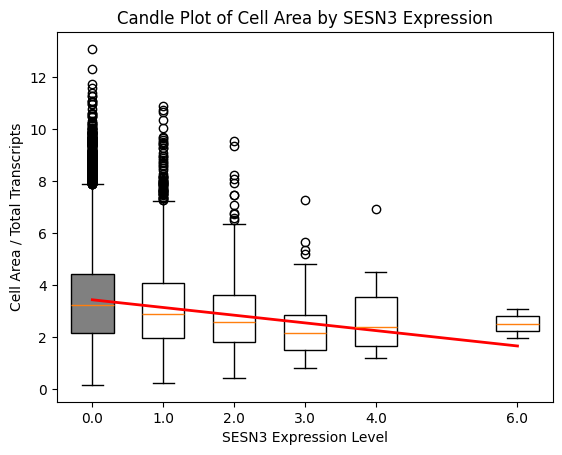

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

goi = "SESN3"
x = np.array(adata[:, goi].X.toarray()).ravel()
y = adata.obs["cell_area"].values
y2 = T / y

uniq_levels = np.unique(x)
groups = [y2[x == lvl] for lvl in uniq_levels]

fig, ax = plt.subplots()
# Enable patch_artist so boxes are Patch objects
bp = ax.boxplot(groups,
                positions=uniq_levels,
                widths=0.6,
                patch_artist=True)

# Color the box at x=0 gray
for lvl, box in zip(uniq_levels, bp['boxes']):
    if lvl == 0:
        box.set_facecolor('gray')
    else:
        box.set_facecolor('white')  # or any other default


slope = df.loc[df['goi'] == goi, 'slope'].values[0]
intercept = df.loc[df['goi'] == goi, 'intercept'].values[0]
x_line = np.linspace(uniq_levels.min(), uniq_levels.max(), 100)
y_line = intercept + slope * x_line
ax.plot(x_line, y_line, color='red',linewidth=2, label=f'y = {slope:.2f}x + {intercept:.2f}')
ax.set_xlabel(f"{goi} Expression Level")
ax.set_ylabel("Cell Area / Total Transcripts")
ax.set_title(f"Candle Plot of Cell Area by {goi} Expression")
plt.show()

In [91]:
print( f" The # of genes has negative expression correlation with cell size {df[df['slope'] < 0].shape[0]}, and positive correlation  {df[df['slope'] > 0].shape[0]}")

 The # of genes has negative expression correlation with cell size 24, and positive correlation  114


In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

regions = [
    ("Region1", "REGION1_TABLES"),
    ("Region3", "REGION3_TABLES"),
    ("Region4", "REGION4_TABLES")
]

goi = "GATOR2"
fig, axes = plt.subplots(1, len(regions), figsize=(4*len(regions), 5), sharey=True)

for ax, (Tissue, TableFolder) in zip(axes, regions):
    # 1) Load and subset
    adata = sc.read_h5ad(f"/Volumes/ProstateCancerEvoMain/dbs/Ongoing/{Tissue}/{TableFolder}/{Tissue}_Xenium_Phen_HE_Integrated.Xenium_Native_Table.Phen_and_ImagePropsEnriched.V2.h5ad")
    annot = sc.read_h5ad(f"/Volumes/ProstateCancerEvoMain/dbs/Ongoing/{Tissue}/{TableFolder}/{Tissue}_Xenium_Phen_HE_Integrated.Xenium_Process_Table.Cell_Type_Annotated_Auto.V3.All_Genes.h5ad")
    adata.obs["cell_type_xenium_panel"] = annot.obs["cell_type_xenium_panel"].values
    adata = adata[adata.obs["cell_type_xenium_panel"] == "tumor_cell_markers", :].copy()
    
    # 2) Compute total transcripts T and y2 = T / cell_area
    expr_all = adata.X
    if hasattr(expr_all, "toarray"):
        T = np.array(expr_all.toarray()).sum(axis=1)
    else:
        T = np.asarray(expr_all.sum(axis=1)).ravel()
    y = adata.obs["cell_area"].values
    y2 = T / y
    
    # 3) Extract SESN3 expression x
    x = np.asarray(adata[:, goi].X.toarray()).ravel()
    
    # 4) Build boxplot data
    uniq_levels = np.unique(x)
    groups = [y2[x == lvl] for lvl in uniq_levels]
    
    # 5) Draw candle plot
    bp = ax.boxplot(
        groups,
        positions=uniq_levels,
        widths=0.6,
        patch_artist=True,
        showfliers=False
    )
    for lvl, box in zip(uniq_levels, bp['boxes']):
        box.set_facecolor('gray' if lvl == 0 else 'white')
    
    # 6) Fit and overlay regression line (discarding zeros)
    mask = x > 0
    slope, intercept, r_val, p_val, se = linregress(x[mask], y2[mask])
    xs = np.linspace(uniq_levels.min(), uniq_levels.max(), 100)
    ys = intercept + slope * xs
    ax.plot(xs, ys, color='red', lw=2,
            label=f"{Tissue}\n y={slope:.2f}x+{intercept:.2f}")
    
    # 7) Labels
    ax.set_title(Tissue)
    ax.set_xlabel(f"{goi} expr.")
    
axes[0].set_ylabel("Cell Area / Total Transcripts")
axes[-1].legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()